### Posteriors on $\bar{x}_{\rm HI} (z)$ from the 21-cm power spectra

---
Importing dependencies

In [1]:
import sys; sys.path.insert(1, "./../../../")
from swyft21cm.utils.interpolation import calc_kSpline, interp_pk, interp_plan
from swyft21cm.utils.plot import plotIonzHist

import os
import seaborn as sns
import numpy as np
np.random.seed(27);

from scipy import stats
import torch
torch.manual_seed(27);

import swyft as sl
import pytorch_lightning as pl
import pickle

from tabulate import tabulate
import matplotlib.pyplot as plt
plt.rcParams["mathtext.fontset"] = "stix"
%matplotlib inline

---
Copy the store to the local gpu computing node

In [2]:
%%time
if not os.path.exists("/tmp/21cmPk_SeedVar"):
    !cp -r /scratch/p303146/21cmPk_SeedVar* /tmp/

CPU times: user 18 µs, sys: 9 µs, total: 27 µs
Wall time: 30.5 µs


---
Redshifts, Prior, Paths

In [3]:
# Redshifts
reds = [24.359810, 20.219959, 17.111031, 14.457590, 12.456770,
        10.714930, 9.402521, 8.237142, 7.202319, 6.429094]

# Parameters: zeta, Tvir, Rmfp, Lx, E0, alpha
labels = [r'$\zeta$', r'$\log_{10}(T_{\rm vir}^{\rm min})$', r'$R_{\rm mfp}$',
          r'$\log_{10}(L_{\rm X})$', r'$E_0$', r'$\alpha_{\rm X}$']

# True values of the parameters
vtrue = np.array([30, 4.69897, 15, 40.5, 500, 1])

# Priors
vmin = np.array([10, 4.2, 8, 39.5, 100, -0.5])
vmax = np.array([100, 5.2, 22, 41.5, 900, 2.5])

# k-modes from sim box (no cut applied)
kModes = np.load("./../../data/kModes.npy")

# Parameters for interpolation
Nspline_points = 8
Foreground_cut = 0.1
Shot_Noise_cut = 0.8

# Path for mock observation and noise
noisePath = "./../../data/ska_low_noise.npy"
obsPath = "./../../data/mockObs.pkl"

# accelerator for the trainer
accelerator = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
kSpline = calc_kSpline(Foreground_cut, Shot_Noise_cut, Nspline_points)
print('k-modes:', kSpline)

k-modes: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]


---
SKA noise simulated using `ps_eor`

In [5]:
# Instrumental noise level from SKA low: sim using ps_eor
instNoise = np.load(noisePath)

---
Mock observation

In [6]:
with open(obsPath, 'rb') as f:
    obs0 = pickle.load(f)

---
Noise model to be used on-the-fly

In [7]:
# Use it as a hook: takes into account the instrumental noise
def noise(out):
    for i in range(len(reds)):
        mu = out['pk_mu_z%.1f'%reds[i]]
        
        # Interpolate the model power spectra (pk_mod)
        splined_mod = interp_plan(k=kModes, pk=mu)
        mu_val = interp_pk(pk_spl=splined_mod, kSpline=kSpline, Nspline_points=Nspline_points)

        # Check for nan values.
        if np.isnan(np.sum(mu_val)):
            mu_val = np.zeros(len(kSpline))

        n = np.float32(np.random.randn(*instNoise[i].shape))*instNoise[i]
        out['pk_z%.1f'%reds[i]] = mu_val + n
    return out

---
Data loaders: Train, Val, Test

In [8]:
zs = sl.ZarrStore("/tmp/21cmPk_SeedVar/")
data_loader_train = zs.get_dataloader(num_workers=0, batch_size=64, idx_range=[0, 16_000],
                                      on_after_load_sample=noise)
data_loader_val = zs.get_dataloader(num_workers=0, batch_size=64, idx_range=[16_000, 18_000],
                                    on_after_load_sample=noise)
data_loader_test = zs.get_dataloader(num_workers=0, batch_size=64, idx_range=[18_000, 20_000],
                                     on_after_load_sample=noise)

---
Trainer, callbacks, logger

In [9]:
logger = pl.loggers.TensorBoardLogger("./lightning_logs", name = "post_xHI")
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor = 'val_loss', save_top_k=1)
callbacks = [
    pl.callbacks.LearningRateMonitor(),
    pl.callbacks.EarlyStopping("val_loss", patience=8),
    model_checkpoint
]

In [10]:
trainer = sl.SwyftTrainer(accelerator=accelerator, max_epochs=100, logger=logger,
                          callbacks=callbacks, precision=64)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


---
Network architecture

In [11]:
class Network(sl.SwyftModule):
    def __init__(self, lr=1e-3, gamma=1.):
        super().__init__()
        self.n_features = 64
        self.optimizer_init = sl.OptimizerInit(torch.optim.Adam, dict(lr = lr),
                                                  torch.optim.lr_scheduler.ExponentialLR,
                                                  dict(gamma = gamma, verbose=False))
        marginals = self.get_marginals(n_params=len(vtrue))
        self.l = torch.nn.Linear(80, self.n_features)
        
        # Train 1D ratios
        self.logratios1 = sl.LogRatioEstimator_1dim(num_features=self.n_features,
                                                    num_params=len(reds),
                                                    hidden_features=256,
                                                    num_blocks=3,
                                                    dropout=0.2,
                                                    varnames='z')

    @staticmethod
    def get_marginals(n_params):
        marginals = []
        for i in range(n_params):
            for j in range(n_params):
                if j>i: marginals.append((i, j))
        return tuple(marginals)
        
    def forward(self, A, B):
        x = torch.cat([A['pk_z%.1f'%zi] for zi in reds], axis=1)
        x = self.l(x)
        z = B['xHI']
        ratios_1 = self.logratios1(x, z)
        return ratios_1

In [12]:
network = Network(lr=1e-3, gamma=0.95)

---
Training the network

In [13]:
%%time
if os.path.exists("./output/01_trainedLogRatios_xHI_20k.pt"):
    network.load_state_dict(torch.load("./output/01_trainedLogRatios_xHI_20k.pt"))
else:
    trainer.fit(network, data_loader_train, data_loader_val)

CPU times: user 16.8 ms, sys: 20.7 ms, total: 37.5 ms
Wall time: 40.9 ms


---
Save the trained model

In [14]:
if not os.path.exists("./output/01_trainedLogRatios_xHI_20k.pt"):
    torch.save(network.state_dict(), "./output/01_trainedLogRatios_xHI_20k.pt")

---
Network's performance on the test dataset

In [15]:
trainer.test(network, data_loader_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-08-08 16:21:58.623877: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 16:22:01.712273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/scratch/p303146/.envs/reach/lib/python3.9/site-packages/pytorch_lightning-1.9.0-py3.9.egg/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home3/p303146/Projects/swyft21cm/analysis/inference/./../../../swyft21cm/utils/interpolation.py:15: RuntimeWarning: divide by zero encountered in log10
  return scipy.interpolate.splrep(k, np.log10(pk), s=0)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    -10.084478098466915    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -10.084478098466915}]

---
Sampling from the prior

In [16]:
prior_samples = sl.Samples(xHI=np.random.rand(200_000, 10).astype('d'))

---
Predictions for the mock observation (`FAINT GALAXIES` model)

In [17]:
pred = trainer.infer(network, sl.Sample(obs0), prior_samples)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/scratch/p303146/.envs/reach/lib/python3.9/site-packages/pytorch_lightning-1.9.0-py3.9.egg/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


---
Posteriors on $\bar{x}_{\rm HI} (z)$

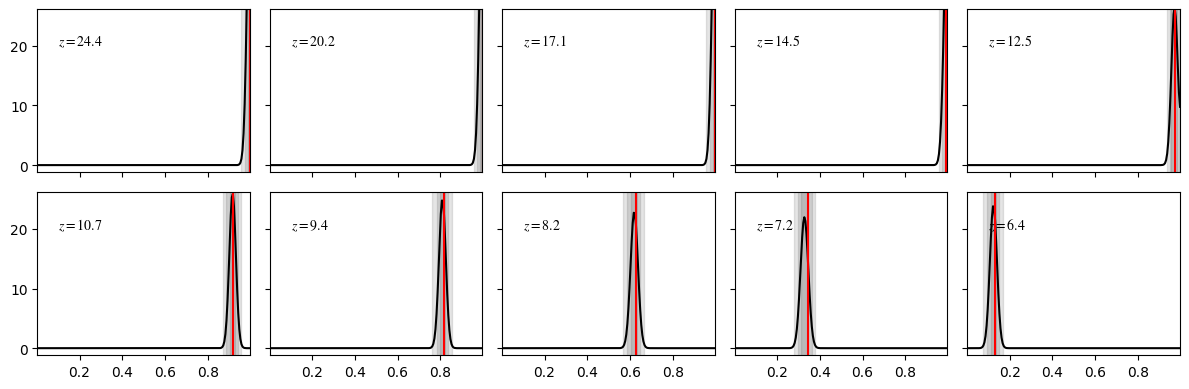

In [18]:
fig, ax = plt.subplots(2, 5, figsize=(12, 4), sharex=True, sharey=True)
cn = 0
for i in range(2):
    for j in range(5):
        sl.plot_1d(pred, "z[%d]"%cn, ax=ax[i, j], bins=200, smooth=3)
        ax[i, j].axvline(obs0['xHI'][cn], color="r")
        ax[i, j].text(0.1, 20, r'$z=%.1f$'%reds[cn])
        cn+=1
plt.tight_layout()
plt.show()

---
Functionality to obtain $(1, 2, 3)\sigma$ intervals

In [19]:
def get_HDI_thresholds(x, cred_level=[0.68268, 0.95450, 0.99730]):
    x = x.flatten()
    x = np.sort(x)[::-1]  # Sort backwards
    total_mass = x.sum()
    enclosed_mass = np.cumsum(x)
    idx = [np.argmax(enclosed_mass >= total_mass * f) for f in cred_level]
    levels = np.array(x[idx])
    return levels

def contour1d(z, v, levels, ax=plt, linestyles=None, color=None, **kwargs):
    y0 = -1.0 * v.max()
    y1 = 5.0 * v.max()
    all_levels_1s = z[np.where(v>levels[2])]
    all_levels_2s = z[np.where(v>levels[1])]
    all_levels_3s = z[np.where(v>levels[0])]
    
    mode = z[np.where(v==v.max())].item()

    min_1s = all_levels_1s[0].item()
    max_1s = all_levels_1s[-1].item()
    
    min_2s = all_levels_2s[0].item()
    max_2s = all_levels_2s[-1].item()
    
    min_3s = all_levels_3s[0].item()
    max_3s = all_levels_3s[-1].item()
    
    # ax.axvline(all_levels_1s[0].numpy(), c="r")
    # ax.axvline(all_levels_1s[-1].numpy(), c="r")
    # ax.axvline(all_levels_2s[0].numpy(), c="g")
    # ax.axvline(all_levels_2s[-1].numpy(), c="g")
    # ax.axvline(all_levels_3s[0].numpy(), c="b")
    # ax.axvline(all_levels_3s[-1].numpy(), c="b")
    
    # ax.fill_between(z, y0, y1, where=v > levels[0], color=color, alpha=0.1)
    # ax.fill_between(z, y0, y1, where=v > levels[1], color=color, alpha=0.1)
    # ax.fill_between(z, y0, y1, where=v > levels[2], color=color, alpha=0.1)
    # ax.set_xlim(all_levels_3s[0].numpy(), all_levels_3s[-1].numpy())
    return mode, min_1s, max_1s, min_2s, max_2s, min_3s, max_3s

def plot_1d(
    logratios,
    parname,
    weights_key=None,
    ax=None,
    grid_interpolate=False,
    bins=100,
    color="k",
    contours=True,
    smooth=0.0,
):
    """Plot 1-dimensional posteriors."""
    v, zm = sl.lightning.utils.get_pdf(logratios, parname, bins=bins, smooth=smooth)
    zm = zm[:, 0]

    levels = sorted(get_HDI_thresholds(v))
    if contours:
        m, min_s1, max_s1, min_s2, max_s2, min_s3, max_s3 = contour1d(zm, v, levels, ax=ax, color=color)
    # ax.plot(zm, v, color=color)
    # ax.set_xlim([zm.min(), zm.max()])
    # ax.set_ylim([-v.max() * 0.05, v.max() * 1.1])
    return m, min_s1, max_s1, min_s2, max_s2, min_s3, max_s3

In [20]:
mode = []
min_s1 = []
max_s1 = []
min_s2 = []
max_s2 = []
for i in range(10):
    m, l_s1, u_s1, l_s2, u_s2, _, _ = plot_1d(pred, "z[%d]"%i, bins=200, smooth=3)
    mode.append(m)
    min_s1.append(m-l_s1)
    max_s1.append(u_s1-m)
    min_s2.append(m-l_s2)
    max_s2.append(u_s2-m)

---
Ionization history constraints!

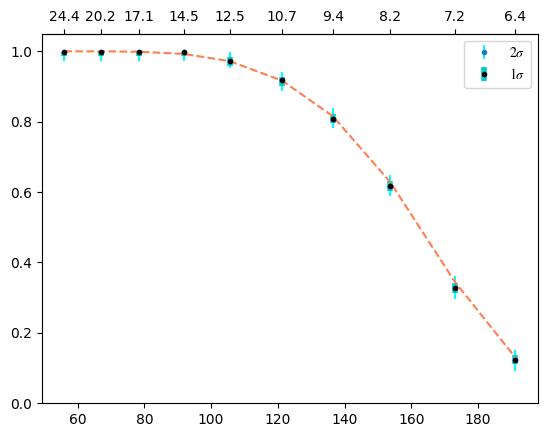

In [21]:
plotIonzHist(reds=reds, mode=mode, min_s1=min_s1, max_s1=max_s1,
            min_s2=min_s2, max_s2=max_s2, obs0=obs0)

---
Save the information

In [22]:
if not os.path.exists("./output/01_xHI_mode_20k.npy"):
    np.save("./output/01_xHI_mode_20k.npy", mode)
    np.save("./output/01_xHI_1sigma_20k.npy", errors_1)
    np.save("./output/01_xHI_2sigma_20k.npy", errors_2)